# Chapter 1: Single cell simulation with current injection (with BioNet)

In this example we will build a network consisting of a single biophysically detailed cell. Then we will run a short simulation with a current injection into the soma of the cell, then look at the output in terms of spikes, membrane potential and calcium flux.

IMAGE: single cell with zap

**Note** - scripts and files for running this tutorial can be found in the directory [sources/chapter01/](sources/chapter01)

requirements:
* bmtk with python
* NEURON 7.4+

## 1. Building the network

We will use the network builder to create and save the network. First we instantiate a network with a name or our choosing (since throughout this tutorial we will use cell models that from the mouse cortex, we will call our network 'mcortex'). 

Once we have a network, we can add a single node by calling the add_nodes method.

In [1]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('mcortex')
net.add_nodes(cell_name='Scnn1a',
              potental='exc',
              level_of_detail='biophysical',
              params_file='472363762_fit.json',
              morphology_file='Scnn1a_473845048_m.swc',
              set_params_function='Biophys1')

Some of the parameters used to create the node are optional and only for our benefit. Others are necessary for when we will eventually run a simulation:
* *cell_name* (optional) - Name/type of cell we will be modeling.
* *potential* (optional) - Use to indicate that it is an excitatory type cell.
* *level_of_detail* - Used by the simulator to indicate that we are using a biophysical cell.
* *params_file* - Model parameters. File will be downloaded from the Allen Cell Types Database. 
* *morphology_file* - Model morphology. File will be downloaded from the Allen Cell Types Database.
* *set_params_function* - A custom function used by the simulator to load the model into NEURON
 
#### Building and saving
The final thing to do is to build and save the network. If successful, we should see a combination of hdf5 and csv files in the './network' directory, these files are used describe the network, and can be saved, stored and run at a later date.

In [2]:
net.build()
net.save_nodes(output_dir='network')

In [3]:
print net.nodes()

## 2. Setting up the simulator enviornment

Now that the network has been built, we can use the BioNet simulator which will setup and run it using NEURON. We will need to set-up the paths to the configuration and parameters files. We can do this by either:
1. Copying the directory tree from LOCATION into the current directory. Then compiling the extra NEURON mechanisms used by the Allen Cell Models by running the command 
```bash
$ cd components/mechanism
$ nrnivmodl modfiles
```
2. We can build the enviornment by scratch, which we can do from a command-line
```bash
$ python -m bmtk.utils.sim_setup -n network --cell-vars cai,v --cell-vars-nodes 0 --run-time 2000.0 bionet
```
   or alternatively just call the function

In [4]:
# from bmtk.utils.sim_setup import build_env_bionet
# build_env_bionet(network_dir='network', cell_vars=['cai', 'v'], cell_vars_nodes=[0], run_time=2000.0)

#### Set the model files
The cell will be modeled from a V1, layer 4 Scnn1a mouse cell. Download the model file from http://celltypes.brain-map.org/neuronal_model/download/482934212, or by searching the Allen Cell-Types Database. We will need to unzip the downloaded package and move the parameters and morphology files into our simulator enviornment:
* Rename *fit_parameters.json* to *472363762_fit.json* and place in ./components/biophysical/electrophysiology/
* Rename *reconstruction.swc* to *Scnn1a_473845048_m.swc* and place in ./components/biophysical/morphologies/ 

In [5]:
%%bash
cp ../../files/components/biophysical/electrophysiology/472363762_fit.json components/biophysical/electrophysiology/
cp ../../files/components/biophysical/morphology/Scnn1a_473845048_m.swc components/biophysical/morphology/

#### Checking the config.json

The file ./config.json is used to set network, run-time and output parameters during a simulation. In the prefered bmtk workflow the config file is used to update and adjust parameters on different simulations runs, eliminating the need for complicated programs and allows modelers and experimentalist to run their models with little-to-no programming required.

More about the configuration file will be explained throughout the tutorials. However current what is missing is any input stimulus. Without it the simulation will run, but not do anything interesting. To add a current injection into the soma of our cell, we must open .config.json with a text editor and modify the **input** section to:
```json
"input": [
    {
      "type": "iclamp",
      "amp" : 0.100,
      "del" : 500.0,
      "dur" : 1000.0
    }
],
```

This will inject a current (amp) of .1 mV with a delay of 500 ms and a duration of 1000 ms (i.e from times 500 - 1500 ms). 


## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py config.json
```

or through the script

In [6]:
import bmtk.simulator.bionet.config as config
from bmtk.simulator.bionet import io, nrn
from bmtk.simulator.bionet.simulation import Simulation
from bmtk.simulator.bionet.biograph import BioGraph
from bmtk.simulator.bionet.bionetwork import BioNetwork
from bmtk.simulator.bionet.property_schemas import AIPropertySchema


conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
graph = BioGraph.from_config(conf, property_schema=AIPropertySchema)
net = BioNetwork.from_config(conf, graph)
sim = Simulation.from_config(conf, network=net)
sim.run()


Overwriting the output directory output:
Created a log file -- on 2017/12/02 at 23:51:36
Output directory: output -- t_wall: 0.853541 s
Config file: /home/kael/workspace/Allen/bmtk/docs/tutorial/notebooks/tutorial_1/config.json -- t_wall: 0.853798 s
Number of processors: 1  -- t_wall: 0.898436 s
Setting up network... -- t_wall: 0.898782 s
    Created morphologies -- t_wall: 0.973827 s
    Set segment properties -- t_wall: 0.977907 s
    Set segment coordinates -- t_wall: 1.058676 s
    Setting up external cells... -- t_wall: 1.059224 s
Cells are built! -- t_wall: 1.05947 s
Initializing connections... -- t_wall: 1.059647 s
    Setting connections from mcortex -- t_wall: 1.059908 s
Network is built! -- t_wall: 1.060054 s
Setting up recordings... -- t_wall: 1.060857 s
    Will save time series of the ECP! -- t_wall: 1.06121 s
    Will save time series of individual cells -- t_wall: 1.063069 s
    Will save spikes -- t_wall: 1.06491 s
Recordings are set! -- t_wall: 1.066341 s
Running simul

A quick breakdown of the script:
```python
conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
```
This section loads the configuration file, it setups the output directory and files for writing during the simulation, and loads NEURON mechanisms needed by the cell model(s) during the simulation.

```python
graph = BioGraph.from_config(conf, property_schema=AIPropertySchema)
```
Creating a BioGraph function will convert the network files created by The Builder to a graph structure.

```python
net = BioNetwork.from_config(conf, graph)
```
Creates a NEURON representation of the network, including cell models that have been converted into their NEURON equivelents.

```python
sim = Simulation.from_config(conf, network=net)
sim.run()
```
Sets up and runs the NEURON simulation. When finished the output - spike times, membrane potential and Calcium influx, will be saved into the output directory as specified in the config.



## 4. Analyzing the run

The results of the simulation are placed into various files as specified in the "output" section of the config file. We can change this before run-time if required.

All simulations will save the spike times of the network cells. These are saved in csv format (output/spikes.txt) or hdf5 format(output/spikes.h5). To get the table of spike times for our single-cell network we can run the following method from the analyzer (gid 0 corresponds to our single cell).

In [9]:
from bmtk.analyzer import spikes_table
spikes_table(config_file='config.json')

,time (ms),cell gid
0,579.9,0
1,633.7,0
2,691.4,0
3,757.2,0
4,833.9,0
5,922.0,0
6,1019.3,0
7,1123.0,0
8,1230.5,0
9,1340.2,0


When setting up the enviornment and config file we specified cell_vars=['v', 'cai']. This indicates to the simulator to also record membrane potential and calcium diffusion (and we can also specify other variables as long as they are supported in NEURON). The recordings are stored in hdf5 format in the file output/cellvars/0.h5 (0 for the gid of our first and only cell).

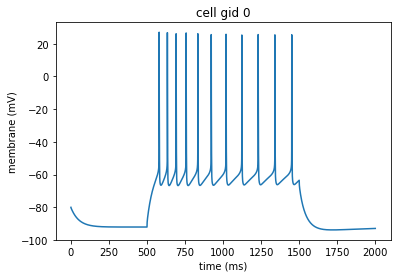

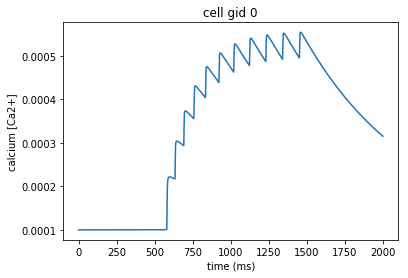

In [10]:
from bmtk.analyzer import plot_potential, plot_calcium

plot_potential(config_file='config.json')
plot_calcium(config_file='config.json')

## 5. Additional Information

### Changing run-time parameters.
By making changes to the config file, we can change the conditions and simulation parameters without having to rebuild the network, modify paramter files, and changing our run_bionet script. In fact we can iteratively run multiple simulations without any extra coding, only a text editor to change the json file.

The run section of the config.json contains most of the parameters unique to the simulation:
```json
"run": {
    "dL": 20, 
    "calc_ecp": false, 
    "nsteps_block": 5000, 
    "spike_threshold": -15, 
    "overwrite_output_dir": true, 
    "save_cell_vars": ["cai", "v"], 
    "tstop": 2000.0, 
    "dt": 0.1
}
```
* dstop - simulation runtime in milliseconds.
* dt - the time steps of the simulation. decreasing dt should increasing accuracy of firing dynamics, but also increase time it takes to complete.
* spike_thresdhold - used to determine when to count a action potential
* save_cell_vars - indicate cell variables that will be recorded (in this case calcium diffusion and membrane potential). 

Through the conditions section we can adjust simulation temperature (C) and the initial membrane potential of the cells:
```json
"conditions": {
    "celsius": 34.0, 
    "v_init": -80
}
```

And lastly, the input section lets us control stimulus onto the network. There are a number of different options which will be explained in the following tutorials. But even with a simple current injection we can adjust amplitude, delay and stimulation duration and measure the effect on the cell.
```json
"input": [
    {
        "amp": 0.1, 
        "dur": 1000.0, 
        "del": 500.0, 
        "type": "iclamp"
    }
]
```
We can even add multiple injections
```json
"input": [
    {
        "type": "iclamp",
        "amp": 0.150, 
        "del": 0.0, 
        "dur": 400.0, 
    },
    {
        "type": "iclamp",
        "amp": 0.300, 
        "del": 0.500, 
        "dur": 400.0, 
    },
    {
        "type": "iclamp",
        "amp": 0.450, 
        "del": 0.1000, 
        "dur": 400.0, 
    }
]
```

### Changing cell models
When building the network we defined the cell model and morphology through the 'params_file' and 'morphology_file' options. After building and saving the network, these values were saved in the node-types csv file.

In [11]:
import pandas as pd
pd.read_csv('network/mcortex_node_types.csv', sep=' ')

,node_type_id,morphology_file,level_of_detail,params_file,potental,set_params_function,cell_name
0,100,Scnn1a_473845048_m.swc,biophysical,472363762_fit.json,exc,Biophys1,Scnn1a


If we want to run the simulation on a different cell model, all we have to do is 
1. Download new parameters.json and morphology.swc into components/biophysical
2. Open mcortex_node_types.csv in a text editor and update 'morphology_file' and 'params_file' accordingly.

In our simple one-cell example, it is likely faster to just rebuild the network. However the advantage of the use of the node types becomes clear once we start dealing with a larger network. For example we may have a network of hundreds of thousands of individual cells with tens of thousands of Scnn1a type cells. The process of adjusting/chaning the Scnn1a parameter in the csv then starting another simulation only takes seconds, whereas rebuilding the entire network may take hours.